In [1]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import timeit
sys.path.append("../..")

from gempy.core.tensor.tensorflow_graph import TFGraph
import tensorflow as tf
import pandas as pd
import gempy as gp
from gempy.assets.geophysics import GravityPreprocessing

def Plot_2D_scaler_field(grid,scaler_field):
    G = grid[np.where(grid[:,1] == [grid[-1][1]])[0]]
    S = scaler_field.numpy()[np.where(grid[:,1] == [grid[0][1]])[0]]
    XX = G[:,0].reshape([50,50])
    ZZ = G[:,2].reshape([50,50])
    S = S.reshape([50,50])
    plt.contour(XX,ZZ,S)


geo_data = gp.create_data([0, 1000, 0, 1000, 0, 1000], resolution=[50, 50, 50],
                          path_o=os.pardir+"/data/input_data/jan_models/model2_orientations.csv",
                          path_i=os.pardir+"/data/input_data/jan_models/model2_surface_points.csv")
gp.map_series_to_surfaces(geo_data, {"Strat_Series": (
    'rock2', 'rock1'), "Basement_Series": ('basement')})

geo_data.add_surface_values([2.61,3.1,2.92])

## Gravity test
## ---------
grav_res = 20
X = np.linspace(0, 1000, grav_res)
Y = np.linspace(0, 1000, grav_res)
Z= 300
xyz= np.meshgrid(X, Y, Z)
xy_ravel = np.vstack(list(map(np.ravel, xyz))).T


geo_data.set_centered_grid(xy_ravel,  resolution = [10, 10, 15], radius=5000)
interpolator = geo_data.interpolator
dtype = interpolator.additional_data.options.df.loc['values', 'dtype']

dips_position, dip_angles, azimuth, polarity, surface_points_coord, fault_drift, grid, values_properties = interpolator.get_python_input_block()[
    0:-3]

g = GravityPreprocessing(geo_data.grid.centered_grid)
tz = g.set_tz_kernel()

len_rest_form = interpolator.additional_data.structure_data.df.loc[
    'values', 'len surfaces surface_points']-1
Range = interpolator.additional_data.kriging_data.df.loc['values', 'range']
C_o = interpolator.additional_data.kriging_data.df.loc['values', '$C_o$']
rescale_factor = interpolator.additional_data.rescaling_data.df.loc[
    'values', 'rescaling factor']
nugget_effect_grad = np.cast[dtype](
    np.tile(interpolator.orientations.df['smooth'], 3))
nugget_effect_scalar = np.cast[interpolator.dtype](
    interpolator.surface_points.df['smooth'])

surface_points_coord = tf.Variable(surface_points_coord,dtype = tf.float64)


TFG = TFGraph(dips_position, dip_angles, azimuth,
  polarity, surface_points_coord, fault_drift,
  grid, values_properties, len_rest_form, Range,
  C_o, nugget_effect_scalar, nugget_effect_grad,
  rescale_factor)


Z_x = TFG.scalar_field()
scalar_field_at_surface_points = TFG.get_scalar_field_at_surface_points(Z_x)
formations_block = TFG.export_formation_block(Z_x,scalar_field_at_surface_points,values_properties)

lg_0 = interpolator.grid.get_grid_args('centered')[0]
lg_1 = interpolator.grid.get_grid_args('centered')[1]
dips_position = tf.convert_to_tensor(dips_position)
dip_angles = tf.convert_to_tensor(dip_angles)
azimuth = tf.convert_to_tensor(azimuth)
polarity = tf.convert_to_tensor(polarity)
surface_points_coord = tf.convert_to_tensor(surface_points_coord)
fault_drift = tf.convert_to_tensor(fault_drift)
grid = tf.convert_to_tensor(grid)
values_properties = tf.convert_to_tensor(values_properties)
len_rest_form = tf.convert_to_tensor(len_rest_form)
Range = tf.convert_to_tensor(Range,tf.float64)
C_o = tf.convert_to_tensor(C_o)
nugget_effect_grad = tf.convert_to_tensor(nugget_effect_grad)
nugget_effect_scalar = tf.convert_to_tensor(nugget_effect_scalar)
rescale_factor = tf.convert_to_tensor(rescale_factor,tf.float64)

densities = formations_block[1][lg_0:lg_1]

grav = TFG.compute_forward_gravity(tz,lg_0,lg_1,densities)



Active grids: ['regular']
Active grids: ['regular' 'centered']
Active grids: ['regular' 'centered']
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


In [3]:
start = timeit.default_timer()
TFG.surface_points_all.assign(TFG.surface_points_all+tf.random.uniform(TFG.surface_points_all.shape,minval=-10., maxval=10.,dtype = tf.float64)/rescale_factor)
Z_x = TFG.scalar_field()
end = timeit.default_timer()
print('time in seconds: %.3f' %(end - start))

time in seconds: 2.218


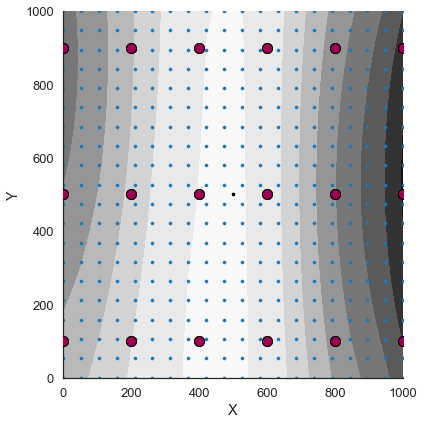

In [2]:
scalar_field_at_surface_points = TFG.get_scalar_field_at_surface_points(Z_x)
formations_block = TFG.export_formation_block(Z_x,scalar_field_at_surface_points,values_properties)

densities = formations_block[1][lg_0:lg_1]

grav = TFG.compute_forward_gravity(tz,lg_0,lg_1,densities)

grav = tf.reshape(grav,[20,20])
### Plot gravity response
xx,yy = np.meshgrid(X,Y)

gp.plot.plot_data(geo_data, direction='z',)
ax = plt.gca()
ax.scatter(xy_ravel[:,0], xy_ravel[:, 1], s=10,zorder=1)
ax.contourf(xx,yy,grav,zorder=-1)

In [9]:
TFG.dips_position_all

array([[0.5001, 0.5001, 0.5551],
       [0.5001, 0.5001, 0.6551]])

In [13]:
tf.expand_dims(TFG.ref_layer_points[:,0],axis = 1)

<tf.Tensor: shape=(34, 1), dtype=float64, numpy=
array([[0.2512831 ],
       [0.2512831 ],
       [0.2512831 ],
       [0.2512831 ],
       [0.2512831 ],
       [0.2512831 ],
       [0.2512831 ],
       [0.2512831 ],
       [0.2512831 ],
       [0.2512831 ],
       [0.2512831 ],
       [0.2512831 ],
       [0.2512831 ],
       [0.2512831 ],
       [0.2512831 ],
       [0.2512831 ],
       [0.2512831 ],
       [0.25056601],
       [0.25056601],
       [0.25056601],
       [0.25056601],
       [0.25056601],
       [0.25056601],
       [0.25056601],
       [0.25056601],
       [0.25056601],
       [0.25056601],
       [0.25056601],
       [0.25056601],
       [0.25056601],
       [0.25056601],
       [0.25056601],
       [0.25056601],
       [0.25056601]])>

In [7]:
TFG.cartesian_dist(TFG.dips_position_all,TFG.ref_layer_points)

<tf.Tensor: shape=(6, 34), dtype=float64, numpy=
array([[0.2488169 , 0.2488169 , 0.2488169 , 0.2488169 , 0.2488169 ,
        0.2488169 , 0.2488169 , 0.2488169 , 0.2488169 , 0.2488169 ,
        0.2488169 , 0.2488169 , 0.2488169 , 0.2488169 , 0.2488169 ,
        0.2488169 , 0.2488169 , 0.24953399, 0.24953399, 0.24953399,
        0.24953399, 0.24953399, 0.24953399, 0.24953399, 0.24953399,
        0.24953399, 0.24953399, 0.24953399, 0.24953399, 0.24953399,
        0.24953399, 0.24953399, 0.24953399, 0.24953399],
       [0.2488169 , 0.2488169 , 0.2488169 , 0.2488169 , 0.2488169 ,
        0.2488169 , 0.2488169 , 0.2488169 , 0.2488169 , 0.2488169 ,
        0.2488169 , 0.2488169 , 0.2488169 , 0.2488169 , 0.2488169 ,
        0.2488169 , 0.2488169 , 0.24953399, 0.24953399, 0.24953399,
        0.24953399, 0.24953399, 0.24953399, 0.24953399, 0.24953399,
        0.24953399, 0.24953399, 0.24953399, 0.24953399, 0.24953399,
        0.24953399, 0.24953399, 0.24953399, 0.24953399],
       [0.19881885, 0

In [ ]:
TFG.surface_points_all

In [ ]:
interpolator.grid.get_grid_args('centered')[1]

In [ ]:
Z_x = TFG.scalar_field()

In [ ]:
surface_points_coord = tf.Variable(surface_points_coord,dtype = tf.float64)

with tf.GradientTape() as t:
    TFG = TFGraph(dips_position, dip_angles, azimuth,
      polarity, surface_points_coord, fault_drift,
      grid, values_properties, len_rest_form, Range,
      C_o, nugget_effect_scalar, nugget_effect_grad,
      rescale_factor)
    t.watch(surface_points_coord)
    

    grid_val = TFG.x_to_interpolate(grid)
    weights = TFG.solve_kriging()

    tiled_weights = TFG.extend_dual_kriging(weights, grid_val.shape[0])

    sigma_0_grad = TFG.contribution_gradient_interface(grid_val, tiled_weights)
    sigma_0_interf = TFG.contribution_interface(grid_val, tiled_weights)
    f_0 = TFG.contribution_universal_drift(grid_val,weights)
    Z_x = TFG.scalar_field()
    scalar_field_at_surface_points = TFG.get_scalar_field_at_surface_points(Z_x)
    formations_block = TFG.export_formation_block(Z_x,scalar_field_at_surface_points,values_properties)

    lg_0 = tf.constant(interpolator.grid.get_grid_args('centered')[0])
    lg_1 = tf.constant(interpolator.grid.get_grid_args('centered')[1])
    densities = formations_block[1][lg_0:lg_1]

    grav = TFG.compute_forward_gravity(tz,lg_0,lg_1,densities)
grad = t.gradient(grav,surface_points_coord)
print(grad)

In [ ]:
lg_0 = interpolator.grid.get_grid_args('centered')[0]
lg_1 = interpolator.grid.get_grid_args('centered')[1]
densities = formations_block[1][lg_0:lg_1]

grav = TFG.compute_forward_gravity(tz,lg_0,lg_1,densities)

In [ ]:
grav = tf.reshape(grav,[20,20])
### Plot gravity response
xx,yy = np.meshgrid(X,Y)

gp.plot.plot_data(geo_data, direction='z')
plt.scatter(xy_ravel[:,0], xy_ravel[:, 1], s=10,zorder=1)
plt.contourf(xx,yy,grav,zorder=-1)

In [ ]:
TFG.ref_layer_points.shape

In [ ]:
TFG.dips_position_all_tiled

In [ ]:
surface_points_coord = tf.Variable(surface_points_coord,dtype = tf.float64)

with tf.GradientTape() as t:
    t.watch(TFG.surface_points_all)
    TFG = TFGraph(dips_position, dip_angles, azimuth,
          polarity, surface_points_coord, fault_drift,
          grid, values_properties, len_rest_form, Range,
          C_o, nugget_effect_scalar, nugget_effect_grad,
          rescale_factor)
    
grad = t.gradient(TFG.rest_layer_points,TFG.surface_points_all)

In [ ]:
@tf.function
def gravity():
    TFG = TFGraph(dips_position, dip_angles, azimuth,
      polarity, surface_points_coord, fault_drift,
      grid, values_properties, len_rest_form, Range,
      C_o, nugget_effect_scalar, nugget_effect_grad,
      rescale_factor)
    grid_val = TFG.x_to_interpolate(grid)

In [ ]:
class Pow(tf.Module):
    def __init__(self, exponent):
        super(Pow, self).__init__()
        self.exponent = tf.Variable(exponent, dtype = tf.float32, name='Pow/exponent')
        
    @tf.function
    def function1(self):
        return tf.constant(2.) ** self.exponenate
    
    @tf.function
    def function2(self):
        self.exponenate = self.exponent+1
        return self.function1()*10

In [ ]:
pow = Pow(3)

In [ ]:
pow.function2()

In [ ]:
pow.exponent.assign(4)
pow.function2()